# Machine Learning Models For Motion Intention Using EMG Signals

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
import math
from utils import *
from mlModels import *

from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.feature_selection as fs
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

import keras
import tensorflow as tf
from keras.models import load_model

In [40]:
keras.backend.clear_session()
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


## Load Data

In [41]:
w_length = 200
w_increment = 100

path = 'D:\Documentos\Datasets\Grabaciones pro'

raw_data, labels, angle, speed, torque = loadAndLabelV2(path, w_length, w_increment)

10_ext_0_31_62.txt
10_flex_0_31_62.txt
10_flex_1333_31_62.txt
10_flex_3638_31_62.txt
10_pron_0_4_62.txt
10_pron_919_4_62.txt
10_stat_0_31_62.txt
10_sup_0_4_62.txt
10_sup_919_4_62.txt
11_ext_0_29_48.txt
11_flex_0_29_48.txt
11_flex_1333_29_48.txt
11_flex_3638_29_48.txt
11_pron_0_3_48.txt
11_pron_919_3_48.txt
11_stat_0_29_48.txt
11_sup_0_3_48.txt
11_sup_919_3_48.txt
12_ext_0_31_66.txt
12_flex_0_31_66.txt
12_flex_1333_31_66.txt
12_flex_3638_31_66.txt
12_pron_0_5_66.txt
12_pron_919_5_66.txt
12_sup_0_5_66.txt
12_sup_919_5_66.txt
13_ext_0_31_70.txt
13_flex_0_31_70.txt
13_flex_1333_31_70.txt
13_flex_3638_31_70.txt
13_pron_0_5_70.txt
13_pron_919_5_70.txt
13_stat_0_5_70.txt
13_sup_0_5_70.txt
13_sup_919_5_70.txt
14_ext_0_29_4.txt
14_flex_0_29_4.txt
14_flex_1333_29_4.txt
14_flex_3638_29_4.txt
14_pron_0_4_48.txt
14_pron_919_4_48.txt
14_stat_0_4_48.txt
14_sup_919_4_48.txt
15_ext_0_29_54.txt
15_flex_0_29_54.txt
15_flex_1333_29_54.txt
15_flex_3638_29_54.txt
15_pron_0_4_54.txt
15_pron_919_4_54.txt
15_s

In [42]:
w, ch = raw_data[0].shape
print('Number of examples (m) = ', len(raw_data))
print('Window lenght (w) = ', w)
print('Number of EMG channels (ch) = ', ch)

Number of examples (m) =  22600
Window lenght (w) =  200
Number of EMG channels (ch) =  4


In [43]:
emg_raw_arr = np.array(raw_data)[:,:,0:4]
labels_arr = np.array(labels)
angle_arr = np.array(angle)
speed_arr = np.array(speed)
torque_arr = np.array(torque)
print(emg_raw_arr.shape)

(22600, 200, 4)


## EMG Features

In [44]:
f_emg_data = EMGfeatures(emg_raw_arr)

sc = MinMaxScaler()
trans = sc.fit_transform(f_emg_data)

print(f_emg_data.shape)

c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '


(22600, 44)


## Moving Average Filter

In [45]:
maf_emg_data = maf(emg_raw_arr)

ascol = maf_emg_data.reshape(-1, ch)
sc = MinMaxScaler()
trans = sc.fit_transform(ascol)

maf_emg_data = trans.reshape(-1, w, ch)
print(maf_emg_data.shape)

maf_emg_data_flat = maf_emg_data.reshape(maf_emg_data.shape[0], w*ch)
print(maf_emg_data_flat.shape)

(22600, 200, 4)
(22600, 800)


## Autoencoder Feature Extraction

In [46]:
cnn_encoder = load_model('encoder_model.h5')
cnn_encoder.summary()

Model: "Convolutional_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 4, 16)        272       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 2, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 2, 8)         520       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 1, 8)         0         
 2D)                                                             
                                                                 
Total params: 792
Trainable params: 792
Non-trainable params: 0
_________________________________________________________________


In [47]:
cnn_encoder.compile(optimizer='adam', loss='binary_crossentropy')
ae_emg = cnn_encoder.predict(emg_raw_arr)
print(ae_emg.shape)

ae_emg_data = ae_emg.reshape(ae_emg.shape[0], ae_emg.shape[1], ae_emg.shape[3])
print(ae_emg_data.shape)

ae_emg_data_flat = ae_emg.reshape(ae_emg.shape[0], -1)
print(ae_emg_data_flat.shape)

707/707 [==============================] - 1s 1ms/step
(22600, 50, 1, 8)
(22600, 50, 8)
(22600, 400)


In [48]:
_, _, Y_train_labels, Y_test_labels = train_test_split(f_emg_data, labels_arr, stratify=labels, test_size=0.1, random_state=1)

X_train_feat, X_test_feat, Y_train_feat, Y_test_feat = train_test_split(f_emg_data, torque_arr, stratify=labels, test_size=0.1, random_state=1)

X_train_maf, X_test_maf, Y_train_maf, Y_test_maf = train_test_split(maf_emg_data, torque_arr, stratify=labels, test_size=0.1, random_state=1)
X_train_maf_flat, X_test_maf_flat, Y_train_maf_flat, Y_test_maf_flat = train_test_split(maf_emg_data_flat, torque_arr, stratify=labels, test_size=0.1, random_state=1)

# X_train_ae, X_test_ae, Y_train_ae, Y_test_ae = train_test_split(ae_emg_data, torque_arr, stratify=labels, test_size=0.1, random_state=1)
# X_train_ae_flat, X_test_ae_flat, Y_train_ae_flat, Y_test_ae_flat = train_test_split(ae_emg_data_flat, torque_arr, stratify=labels, test_size=0.1, random_state=1)

# Torque Regression Training

## EMG Features

In [11]:
models_reg, models_names_reg = sklearnModelsReg()
train_scores, val_scores = cvRegression(X_train_feat, Y_train_feat, Y_train_labels, models_reg, k=5)

c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\alejo\AppData\Local\Programs\Pyt

In [12]:
mlp_train_scores, mlp_val_scores = cvKerasReg(X_train_feat, Y_train_feat, Y_train_labels, mlpReg(), k = 5)
models_names_reg.append('Deep MLP')
train_scores[0].append(mlp_train_scores[0])
train_scores[1].append(mlp_train_scores[1])
train_scores[2].append(mlp_train_scores[2])
val_scores[0].append(mlp_val_scores[0])
val_scores[1].append(mlp_val_scores[1])
val_scores[2].append(mlp_val_scores[2])

Epoch 1/200
64/64 [==============================] - 1s 3ms/step - loss: 7.8551 - mean_absolute_error: 1.8721 - mean_squared_error: 7.8551
Epoch 2/200
64/64 [==============================] - 0s 3ms/step - loss: 6.0310 - mean_absolute_error: 1.5821 - mean_squared_error: 6.0310
Epoch 3/200
64/64 [==============================] - 0s 2ms/step - loss: 5.8699 - mean_absolute_error: 1.5972 - mean_squared_error: 5.8699
Epoch 4/200
64/64 [==============================] - 0s 2ms/step - loss: 5.5932 - mean_absolute_error: 1.5513 - mean_squared_error: 5.5932
Epoch 5/200
64/64 [==============================] - 0s 2ms/step - loss: 5.4748 - mean_absolute_error: 1.5294 - mean_squared_error: 5.4748
Epoch 6/200
64/64 [==============================] - 0s 2ms/step - loss: 5.4099 - mean_absolute_error: 1.5271 - mean_squared_error: 5.4099
Epoch 7/200
64/64 [==============================] - 0s 2ms/step - loss: 5.3558 - mean_absolute_error: 1.5201 - mean_squared_error: 5.3558
Epoch 8/200
64/64 [========

In [17]:
cols = pd.MultiIndex.from_product([['Train', 'Val'], ['MAE', 'MSE', 'R2']],names=['','Model'])
models_comparison_reg = pd.DataFrame(zip(train_scores[0], train_scores[1], train_scores[2], val_scores[0], val_scores[1], val_scores[2]), index=models_names_reg, columns=cols)
models_comparison_reg = models_comparison_reg.sort_values([('Val', 'MAE')], ascending=True)
models_comparison_reg


Train                              Val              \
Model                   MAE         MSE         R2       MAE         MSE   
Random Forest      0.418402    0.542517   0.951017  1.124615    3.855521   
Bagging            0.465810    0.779091   0.929658  1.182089    4.298999   
Deep MLP           0.998403    2.525061   0.771943  1.205121    3.800808   
MLP                1.318033    4.257556   0.615579  1.357390    4.522329   
SVM                1.379335    6.487756   0.414229  1.382845    6.501628   
Ridge              1.510005    5.493144   0.504039  1.513229    5.517207   
Linear Regression  1.524575    5.443913   0.508485  1.529407    5.480456   
Elastic-Net        1.660364    6.385527   0.423466  1.661336    6.393440   
Lasso              1.693060    6.490859   0.413955  1.694039    6.498096   
LARS               6.608761  250.982672 -21.759046  6.658927  246.225971   

                              
Model                     R2  
Random Forest       0.651852  
Bagging             0.611760  
Deep MLP            0.657241  
MLP                 0.591671  
SVM                 0.412823  
Ridge               0.501717  
Linear Regression   0.505076  
Elastic-Net         0.422579  
Lasso               0.413130  
LARS              -20.858319

## Moving Average Filter

In [20]:
lr = LinearRegression()
rr = Ridge()
lsr = Lasso()
en = ElasticNet()
lars = Lars()
models_reg = [lr, rr, lsr, en, lars]
models_names_reg = ['Linear Regression', 'Ridge', 'Lasso', 'Elastic-Net', 'LARS']
train_scores, val_scores = cvRegression(X_train_maf_flat, Y_train_maf_flat, Y_train_labels, models_reg, k=5)

c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing s

In [21]:
mlp_train_scores, mlp_val_scores = cvKerasReg(X_train_maf_flat, Y_train_maf_flat, Y_train_labels, mlpReg(), k = 5)
models_names_reg.append('Deep MLP')
train_scores[0].append(mlp_train_scores[0])
train_scores[1].append(mlp_train_scores[1])
train_scores[2].append(mlp_train_scores[2])
val_scores[0].append(mlp_val_scores[0])
val_scores[1].append(mlp_val_scores[1])
val_scores[2].append(mlp_val_scores[2])

Epoch 1/200
64/64 [==============================] - 1s 4ms/step - loss: 7.0852 - mean_absolute_error: 1.7113 - mean_squared_error: 7.0852
Epoch 2/200
64/64 [==============================] - 0s 4ms/step - loss: 6.1315 - mean_absolute_error: 1.5762 - mean_squared_error: 6.1315
Epoch 3/200
64/64 [==============================] - 0s 3ms/step - loss: 6.0532 - mean_absolute_error: 1.5655 - mean_squared_error: 6.0532
Epoch 4/200
64/64 [==============================] - 0s 3ms/step - loss: 5.8928 - mean_absolute_error: 1.5186 - mean_squared_error: 5.8928
Epoch 5/200
64/64 [==============================] - 0s 2ms/step - loss: 5.7144 - mean_absolute_error: 1.4923 - mean_squared_error: 5.7144
Epoch 6/200
64/64 [==============================] - 0s 3ms/step - loss: 5.5779 - mean_absolute_error: 1.4713 - mean_squared_error: 5.5779
Epoch 7/200
64/64 [==============================] - 0s 3ms/step - loss: 5.4220 - mean_absolute_error: 1.4332 - mean_squared_error: 5.4220
Epoch 8/200
64/64 [========

In [22]:
cnn_train_scores, cnn_val_scores = cvKerasReg(X_train_maf.reshape(X_train_maf.shape[0],w,ch,1), Y_train_maf, Y_train_labels, cnnReg(), k = 5)
models_names_reg.append('CNN')
train_scores[0].append(cnn_train_scores[0])
train_scores[1].append(cnn_train_scores[1])
train_scores[2].append(cnn_train_scores[2])
val_scores[0].append(cnn_val_scores[0])
val_scores[1].append(cnn_val_scores[1])
val_scores[2].append(cnn_val_scores[2])

Epoch 1/200
64/64 [==============================] - 2s 6ms/step - loss: 10.3848 - mean_absolute_error: 2.0849 - mean_squared_error: 10.3848
Epoch 2/200
64/64 [==============================] - 0s 5ms/step - loss: 6.3659 - mean_absolute_error: 1.6426 - mean_squared_error: 6.3659
Epoch 3/200
64/64 [==============================] - 0s 5ms/step - loss: 6.0600 - mean_absolute_error: 1.5552 - mean_squared_error: 6.0600
Epoch 4/200
64/64 [==============================] - 0s 5ms/step - loss: 5.9425 - mean_absolute_error: 1.5131 - mean_squared_error: 5.9425
Epoch 5/200
64/64 [==============================] - 0s 5ms/step - loss: 5.7991 - mean_absolute_error: 1.4856 - mean_squared_error: 5.7991
Epoch 6/200
64/64 [==============================] - 0s 5ms/step - loss: 5.6957 - mean_absolute_error: 1.4762 - mean_squared_error: 5.6957
Epoch 7/200
64/64 [==============================] - 0s 5ms/step - loss: 5.5587 - mean_absolute_error: 1.4533 - mean_squared_error: 5.5587
Epoch 8/200
64/64 [======

In [23]:
lstm_train_scores, lstm_val_scores = cvKerasReg(X_train_maf, Y_train_maf, Y_train_labels, lstm_rnnReg(), k = 5)
models_names_reg.append('LSTM')
train_scores[0].append(lstm_train_scores[0])
train_scores[1].append(lstm_train_scores[1])
train_scores[2].append(lstm_train_scores[2])
val_scores[0].append(lstm_val_scores[0])
val_scores[1].append(lstm_val_scores[1])
val_scores[2].append(lstm_val_scores[2])

Epoch 1/200
64/64 [==============================] - 3s 15ms/step - loss: 12.5333 - mean_absolute_error: 2.1152 - mean_squared_error: 12.5333
Epoch 2/200
64/64 [==============================] - 1s 14ms/step - loss: 8.7832 - mean_absolute_error: 1.9617 - mean_squared_error: 8.7832
Epoch 3/200
64/64 [==============================] - 1s 14ms/step - loss: 7.2065 - mean_absolute_error: 1.6543 - mean_squared_error: 7.2065
Epoch 4/200
64/64 [==============================] - 1s 15ms/step - loss: 7.4138 - mean_absolute_error: 1.7825 - mean_squared_error: 7.4138
Epoch 5/200
64/64 [==============================] - 1s 14ms/step - loss: 7.3611 - mean_absolute_error: 1.7124 - mean_squared_error: 7.3611
Epoch 6/200
64/64 [==============================] - 1s 13ms/step - loss: 6.3920 - mean_absolute_error: 1.5953 - mean_squared_error: 6.3920
Epoch 7/200
64/64 [==============================] - 1s 13ms/step - loss: 7.4276 - mean_absolute_error: 1.7048 - mean_squared_error: 7.4276
Epoch 8/200
64/64 

In [24]:
gru_train_scores, gru_val_scores = cvKerasReg(X_train_maf, Y_train_maf, Y_train_labels, gru_rnnReg(), k = 5)
models_names_reg.append('GRU')
train_scores[0].append(gru_train_scores[0])
train_scores[1].append(gru_train_scores[1])
train_scores[2].append(gru_train_scores[2])
val_scores[0].append(gru_val_scores[0])
val_scores[1].append(gru_val_scores[1])
val_scores[2].append(gru_val_scores[2])

Epoch 1/200
64/64 [==============================] - 3s 17ms/step - loss: 12.4450 - mean_absolute_error: 2.0759 - mean_squared_error: 12.4450
Epoch 2/200
64/64 [==============================] - 1s 16ms/step - loss: 8.8248 - mean_absolute_error: 2.0461 - mean_squared_error: 8.8248
Epoch 3/200
64/64 [==============================] - 1s 16ms/step - loss: 6.0912 - mean_absolute_error: 1.5175 - mean_squared_error: 6.0912
Epoch 4/200
64/64 [==============================] - 1s 15ms/step - loss: 5.7529 - mean_absolute_error: 1.4838 - mean_squared_error: 5.7529
Epoch 5/200
64/64 [==============================] - 1s 16ms/step - loss: 5.6242 - mean_absolute_error: 1.4604 - mean_squared_error: 5.6242
Epoch 6/200
64/64 [==============================] - 1s 15ms/step - loss: 5.5408 - mean_absolute_error: 1.4574 - mean_squared_error: 5.5408
Epoch 7/200
64/64 [==============================] - 1s 15ms/step - loss: 5.4768 - mean_absolute_error: 1.4535 - mean_squared_error: 5.4768
Epoch 8/200
64/64 

In [27]:
cols = pd.MultiIndex.from_product([['Train', 'Val'], ['MAE', 'MSE', 'R2']],names=['','Model'])
models_comparison_reg = pd.DataFrame(zip(train_scores[0], train_scores[1], train_scores[2], val_scores[0], val_scores[1], val_scores[2]), index=models_names_reg, columns=cols)
models_comparison_reg = models_comparison_reg.sort_values([('Val', 'MAE')], ascending=True)
models_comparison_reg

Train                                       Val  \
Model                       MAE           MSE            R2           MAE   
Deep MLP               0.592655  8.560946e-01  9.226670e-01      1.133384   
GRU                    1.214670  4.086762e+00  6.309708e-01      1.263471   
LSTM                   1.283694  4.448847e+00  5.982750e-01      1.321772   
CNN                    1.194273  3.656870e+00  6.697871e-01      1.334742   
Ridge                  1.552340  5.910288e+00  4.663726e-01      1.582093   
Linear Regression      1.510194  5.481131e+00  5.051198e-01      1.657157   
Lasso                  2.372539  1.107585e+01  0.000000e+00      2.372695   
Elastic-Net            2.372539  1.107585e+01  0.000000e+00      2.372695   
LARS               57544.193635  4.409214e+10 -3.958523e+09  62675.063088   

                                               
Model                       MSE            R2  
Deep MLP           3.611202e+00  6.749806e-01  
GRU                4.472326e+00  5.965197e-01  
LSTM               4.751841e+00  5.711603e-01  
CNN                4.680968e+00  5.775763e-01  
Ridge              6.212252e+00  4.389019e-01  
Linear Regression  6.897115e+00  3.770362e-01  
Lasso              1.107678e+01 -2.109336e-04  
Elastic-Net        1.107678e+01 -2.109336e-04  
LARS               6.500320e+10 -6.004889e+09

## Autoencoder Feature Extraction

In [15]:
lr = LinearRegression()
rr = Ridge()
lsr = Lasso()
en = ElasticNet()
lars = Lars()
models_reg = [lr, rr, lsr, en, lars]
models_names_reg = ['Linear Regression', 'Ridge', 'Lasso', 'Elastic-Net', 'LARS']
train_scores, val_scores = cvRegression(X_train_ae_flat, Y_train_ae_flat, Y_train_labels, models_reg, k=5)

c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing s

In [16]:
mlp_train_scores, mlp_val_scores = cvKerasReg(X_train_ae_flat, Y_train_ae_flat, Y_train_labels, mlpReg(), k = 5)
models_names_reg.append('Deep MLP')
train_scores[0].append(mlp_train_scores[0])
train_scores[1].append(mlp_train_scores[1])
train_scores[2].append(mlp_train_scores[2])
val_scores[0].append(mlp_val_scores[0])
val_scores[1].append(mlp_val_scores[1])
val_scores[2].append(mlp_val_scores[2])

Epoch 1/200
64/64 [==============================] - 0s 3ms/step - loss: 9.0362 - mean_absolute_error: 1.9485 - mean_squared_error: 9.0362
Epoch 2/200
64/64 [==============================] - 0s 3ms/step - loss: 7.4838 - mean_absolute_error: 1.8435 - mean_squared_error: 7.4838
Epoch 3/200
64/64 [==============================] - 0s 3ms/step - loss: 6.6784 - mean_absolute_error: 1.6826 - mean_squared_error: 6.6784
Epoch 4/200
64/64 [==============================] - 0s 3ms/step - loss: 6.3969 - mean_absolute_error: 1.6180 - mean_squared_error: 6.3969
Epoch 5/200
64/64 [==============================] - 0s 3ms/step - loss: 6.2569 - mean_absolute_error: 1.5966 - mean_squared_error: 6.2569
Epoch 6/200
64/64 [==============================] - 0s 2ms/step - loss: 6.1984 - mean_absolute_error: 1.5778 - mean_squared_error: 6.1984
Epoch 7/200
64/64 [==============================] - 0s 2ms/step - loss: 6.0639 - mean_absolute_error: 1.5735 - mean_squared_error: 6.0639
Epoch 8/200
64/64 [========

In [17]:
cnn_train_scores, cnn_val_scores = cvKerasReg(X_train_ae.reshape(X_train_ae.shape[0],X_train_ae.shape[1],X_train_ae.shape[2],1), Y_train_ae, Y_train_labels, cnnReg(), k = 5)
models_names_reg.append('CNN')
train_scores[0].append(cnn_train_scores[0])
train_scores[1].append(cnn_train_scores[1])
train_scores[2].append(cnn_train_scores[2])
val_scores[0].append(cnn_val_scores[0])
val_scores[1].append(cnn_val_scores[1])
val_scores[2].append(cnn_val_scores[2])

Epoch 1/200
64/64 [==============================] - 1s 8ms/step - loss: 9.5316 - mean_absolute_error: 2.0135 - mean_squared_error: 9.5316
Epoch 2/200
64/64 [==============================] - 0s 3ms/step - loss: 8.1551 - mean_absolute_error: 1.9251 - mean_squared_error: 8.1551
Epoch 3/200
64/64 [==============================] - 0s 3ms/step - loss: 7.4896 - mean_absolute_error: 1.8416 - mean_squared_error: 7.4896
Epoch 4/200
64/64 [==============================] - 0s 3ms/step - loss: 6.4040 - mean_absolute_error: 1.6688 - mean_squared_error: 6.4040
Epoch 5/200
64/64 [==============================] - 0s 3ms/step - loss: 5.9863 - mean_absolute_error: 1.5720 - mean_squared_error: 5.9863
Epoch 6/200
64/64 [==============================] - 0s 3ms/step - loss: 5.8765 - mean_absolute_error: 1.5397 - mean_squared_error: 5.8765
Epoch 7/200
64/64 [==============================] - 0s 3ms/step - loss: 5.7942 - mean_absolute_error: 1.5233 - mean_squared_error: 5.7942
Epoch 8/200
64/64 [========

In [18]:
lstm_train_scores, lstm_val_scores = cvKerasReg(X_train_ae, Y_train_ae, Y_train_labels, lstm_rnnReg(), k = 5)
models_names_reg.append('LSTM')
train_scores[0].append(lstm_train_scores[0])
train_scores[1].append(lstm_train_scores[1])
train_scores[2].append(lstm_train_scores[2])
val_scores[0].append(lstm_val_scores[0])
val_scores[1].append(lstm_val_scores[1])
val_scores[2].append(lstm_val_scores[2])

Epoch 1/200
64/64 [==============================] - 3s 8ms/step - loss: 11.6409 - mean_absolute_error: 2.1018 - mean_squared_error: 11.6409
Epoch 2/200
64/64 [==============================] - 0s 7ms/step - loss: 8.0843 - mean_absolute_error: 1.9059 - mean_squared_error: 8.0843
Epoch 3/200
64/64 [==============================] - 0s 7ms/step - loss: 6.2678 - mean_absolute_error: 1.5951 - mean_squared_error: 6.2678
Epoch 4/200
64/64 [==============================] - 0s 6ms/step - loss: 5.8794 - mean_absolute_error: 1.5179 - mean_squared_error: 5.8794
Epoch 5/200
64/64 [==============================] - 0s 6ms/step - loss: 5.7462 - mean_absolute_error: 1.4837 - mean_squared_error: 5.7462
Epoch 6/200
64/64 [==============================] - 0s 7ms/step - loss: 5.7197 - mean_absolute_error: 1.4825 - mean_squared_error: 5.7197
Epoch 7/200
64/64 [==============================] - 0s 6ms/step - loss: 5.6627 - mean_absolute_error: 1.4766 - mean_squared_error: 5.6627
Epoch 8/200
64/64 [======

In [19]:
gru_train_scores, gru_val_scores = cvKerasReg(X_train_ae, Y_train_ae, Y_train_labels, gru_rnnReg(), k = 5)
models_names_reg.append('GRU')
train_scores[0].append(gru_train_scores[0])
train_scores[1].append(gru_train_scores[1])
train_scores[2].append(gru_train_scores[2])
val_scores[0].append(gru_val_scores[0])
val_scores[1].append(gru_val_scores[1])
val_scores[2].append(gru_val_scores[2])

Epoch 1/200
64/64 [==============================] - 2s 8ms/step - loss: 12.5048 - mean_absolute_error: 2.0375 - mean_squared_error: 12.5048
Epoch 2/200
64/64 [==============================] - 0s 6ms/step - loss: 9.3841 - mean_absolute_error: 2.2067 - mean_squared_error: 9.3841
Epoch 3/200
64/64 [==============================] - 0s 6ms/step - loss: 7.6389 - mean_absolute_error: 1.8060 - mean_squared_error: 7.6389
Epoch 4/200
64/64 [==============================] - 0s 6ms/step - loss: 6.2626 - mean_absolute_error: 1.5797 - mean_squared_error: 6.2626
Epoch 5/200
64/64 [==============================] - 0s 6ms/step - loss: 5.9112 - mean_absolute_error: 1.5079 - mean_squared_error: 5.9112
Epoch 6/200
64/64 [==============================] - 0s 6ms/step - loss: 5.8037 - mean_absolute_error: 1.4942 - mean_squared_error: 5.8037
Epoch 7/200
64/64 [==============================] - 0s 6ms/step - loss: 5.6869 - mean_absolute_error: 1.4823 - mean_squared_error: 5.6869
Epoch 8/200
64/64 [======

In [20]:
cols = pd.MultiIndex.from_product([['Train', 'Val'], ['MAE', 'MSE', 'R2']],names=['','Model'])
models_comparison_reg = pd.DataFrame(zip(train_scores[0], train_scores[1], train_scores[2], val_scores[0], val_scores[1], val_scores[2]), index=models_names_reg, columns=cols)
models_comparison_reg = models_comparison_reg.sort_values([('Val', 'MAE')], ascending=True)
models_comparison_reg

Train                                     Val  \
Model                     MAE           MSE            R2         MAE   
Deep MLP             0.317829      0.223940  9.797462e-01    0.972530   
GRU                  1.102997      3.567226  6.778689e-01    1.198746   
LSTM                 1.110605      3.490692  6.847206e-01    1.223211   
CNN                  0.978944      2.561549  7.686605e-01    1.254606   
Ridge                1.562440      5.952667  4.625454e-01    1.616492   
Linear Regression    1.559202      5.903928  4.669456e-01    1.634515   
Lasso                2.372539     11.075846 -3.774758e-16    2.372695   
Elastic-Net          2.372539     11.075846 -3.774758e-16    2.372695   
LARS               131.990646  82743.920235 -7.461918e+03  142.477961   

                                               
Model                        MSE           R2  
Deep MLP                3.070226     0.723534  
GRU                     4.319904     0.610362  
LSTM                    4.362708     0.606445  
CNN                     4.537637     0.590626  
Ridge                   6.475450     0.415132  
Linear Regression       6.640679     0.400172  
Lasso                  11.076782    -0.000211  
Elastic-Net            11.076782    -0.000211  
LARS               106594.137935 -9662.453605

# Model Test

In [43]:
X_train_feat, X_test_feat, Y_train_feat, Y_test_feat = train_test_split(f_emg_data, torque_arr, test_size=0.3, shuffle=False)

X_train_ae_flat, X_test_ae_flat, Y_train_ae_flat, Y_test_ae_flat = train_test_split(ae_emg_data_flat, torque_arr, test_size=0.3, shuffle=False)

In [56]:
rf = RandomForestRegressor()
rf.fit(X_train_feat, Y_train_feat)

RandomForestRegressor()

Train MAE =  0.06756665236467345
Test MAE =  0.18316534462661943


Text(0.5, 0, 'Ventana')

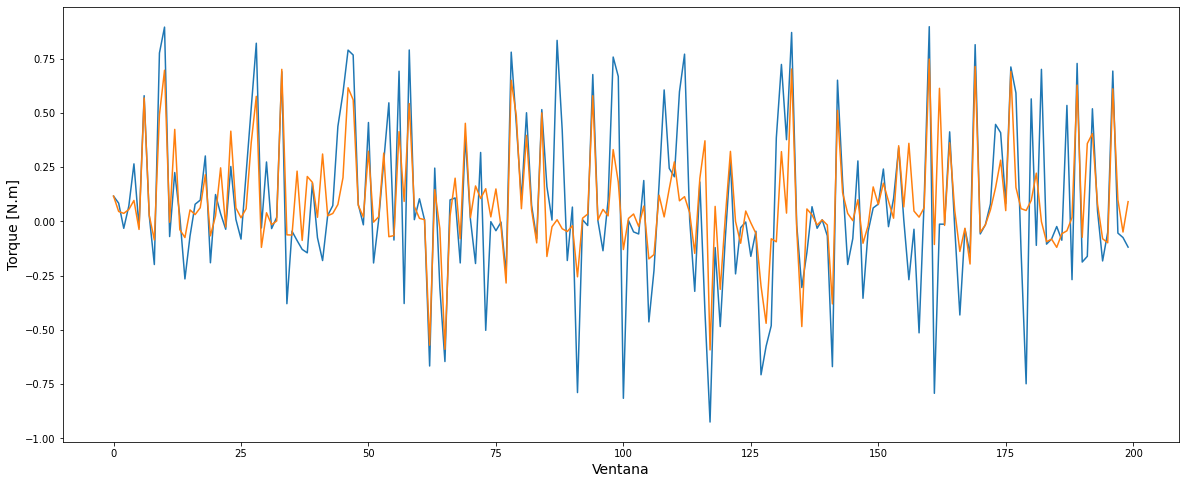

In [57]:
predicted = rf.predict(X_train_feat)
print("Train MAE = ", mean_absolute_error(Y_train_feat, predicted))
predicted = rf.predict(X_test_feat)
print("Test MAE = ", mean_absolute_error(Y_test_feat, predicted))

n = 200
plt.figure(figsize=(20,8))
plt.plot(Y_test_ae_flat[0:n])
plt.plot(predicted[0:n])
plt.ylabel("Torque [N.m]", fontsize=14)
plt.xlabel("Ventana", fontsize=14)

In [58]:
deep_mlp = mlpReg()
deep_mlp.compile(optimizer='adam', loss='mean_squared_error', metrics=['MeanAbsoluteError','MeanSquaredError','RootMeanSquaredError'])
deep_mlp.fit(x=X_train_ae_flat, y=Y_train_ae_flat, epochs=200, batch_size=256)

Epoch 1/200
80/80 [==============================] - 1s 6ms/step - loss: 0.1375 - mean_absolute_error: 0.2707 - mean_squared_error: 0.1375 - root_mean_squared_error: 0.3708
Epoch 2/200
80/80 [==============================] - 0s 6ms/step - loss: 0.1301 - mean_absolute_error: 0.2619 - mean_squared_error: 0.1301 - root_mean_squared_error: 0.3607
Epoch 3/200
80/80 [==============================] - 0s 6ms/step - loss: 0.1260 - mean_absolute_error: 0.2568 - mean_squared_error: 0.1260 - root_mean_squared_error: 0.3550
Epoch 4/200
80/80 [==============================] - 0s 6ms/step - loss: 0.1236 - mean_absolute_error: 0.2535 - mean_squared_error: 0.1236 - root_mean_squared_error: 0.3516
Epoch 5/200
80/80 [==============================] - 1s 6ms/step - loss: 0.1193 - mean_absolute_error: 0.2483 - mean_squared_error: 0.1193 - root_mean_squared_error: 0.3454
Epoch 6/200
80/80 [==============================] - 1s 6ms/step - loss: 0.1155 - mean_absolute_error: 0.2436 - mean_squared_error: 0.1

In [59]:
deep_mlp.evaluate(X_train_ae_flat,Y_train_ae_flat)
deep_mlp.evaluate(X_test_ae_flat,Y_test_ae_flat)

71/71 [==============================] - 0s 5ms/step - loss: 0.2106 - mean_absolute_error: 0.3257 - mean_squared_error: 0.2106 - root_mean_squared_error: 0.4589


[0.21055366098880768,
 0.3257153332233429,
 0.21055366098880768,
 0.45886126160621643]

71/71 [==============================] - 0s 2ms/step


Text(0.5, 0, 'Ventana')

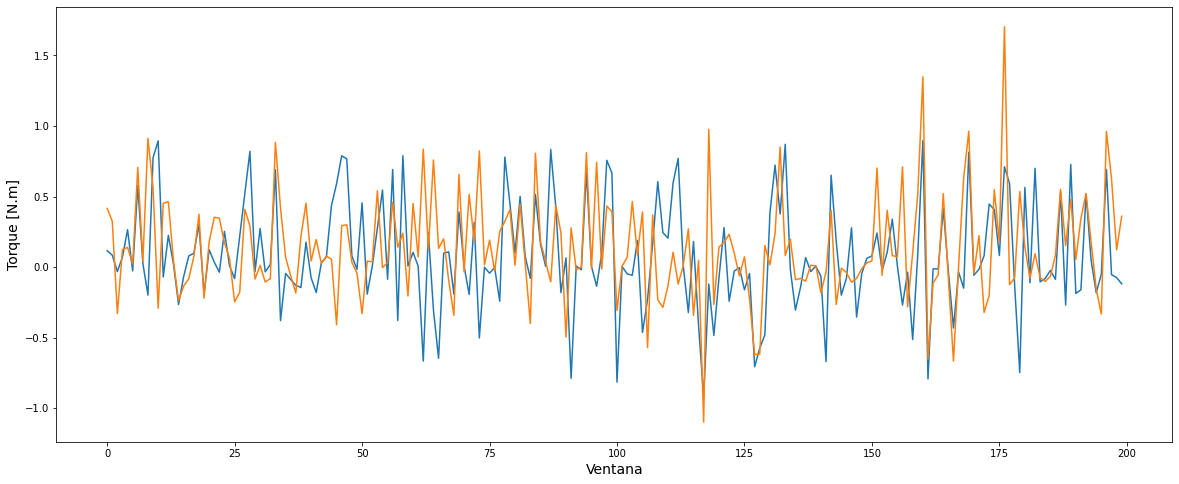

In [60]:
predicted = deep_mlp.predict(X_test_ae_flat)
n = 200
plt.figure(figsize=(20,8))
plt.plot(Y_test_ae_flat[0:n])
plt.plot(predicted[0:n])
plt.ylabel("Torque [N.m]", fontsize=14)
plt.xlabel("Ventana", fontsize=14)

# Speed Regression Training

In [48]:
X_train_feat, X_test_feat, Y_train_feat, Y_test_feat = train_test_split(f_emg_data, np.radians(speed_arr), stratify=labels, test_size=0.1, random_state=1)

X_train_maf, X_test_maf, Y_train_maf, Y_test_maf = train_test_split(maf_emg_data, np.radians(speed_arr), stratify=labels, test_size=0.1, random_state=1)
X_train_maf_flat, X_test_maf_flat, Y_train_maf_flat, Y_test_maf_flat = train_test_split(maf_emg_data_flat, np.radians(speed_arr), stratify=labels, test_size=0.1, random_state=1)

X_train_ae, X_test_ae, Y_train_ae, Y_test_ae = train_test_split(ae_emg_data, np.radians(speed_arr), stratify=labels, test_size=0.1, random_state=1)
X_train_ae_flat, X_test_ae_flat, Y_train_ae_flat, Y_test_ae_flat = train_test_split(ae_emg_data_flat, np.radians(speed_arr), stratify=labels, test_size=0.1, random_state=1)

## EMG Features

In [49]:
models_reg, models_names_reg = sklearnModelsReg()
train_scores, val_scores = cvRegression(X_train_feat, Y_train_feat, Y_train_labels, models_reg, k=5)

c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing s

In [50]:
mlp_train_scores, mlp_val_scores = cvKerasReg(X_train_feat, Y_train_feat, Y_train_labels, mlpReg(), k = 5)
models_names_reg.append('Deep MLP')
train_scores[0].append(mlp_train_scores[0])
train_scores[1].append(mlp_train_scores[1])
train_scores[2].append(mlp_train_scores[2])
val_scores[0].append(mlp_val_scores[0])
val_scores[1].append(mlp_val_scores[1])
val_scores[2].append(mlp_val_scores[2])

Epoch 1/200
64/64 [==============================] - 1s 4ms/step - loss: 3.5284 - mean_absolute_error: 1.4188 - mean_squared_error: 3.5284
Epoch 2/200
64/64 [==============================] - 0s 3ms/step - loss: 2.9788 - mean_absolute_error: 1.2724 - mean_squared_error: 2.9788
Epoch 3/200
64/64 [==============================] - 0s 3ms/step - loss: 2.9516 - mean_absolute_error: 1.2659 - mean_squared_error: 2.9516
Epoch 4/200
64/64 [==============================] - 0s 3ms/step - loss: 2.9427 - mean_absolute_error: 1.2619 - mean_squared_error: 2.9427
Epoch 5/200
64/64 [==============================] - 0s 3ms/step - loss: 2.9824 - mean_absolute_error: 1.2811 - mean_squared_error: 2.9824
Epoch 6/200
64/64 [==============================] - 0s 3ms/step - loss: 2.9137 - mean_absolute_error: 1.2531 - mean_squared_error: 2.9137
Epoch 7/200
64/64 [==============================] - 0s 3ms/step - loss: 2.9131 - mean_absolute_error: 1.2555 - mean_squared_error: 2.9131
Epoch 8/200
64/64 [========

In [51]:
cols = pd.MultiIndex.from_product([['Train', 'Val'], ['MAE', 'MSE', 'R2']],names=['','Model'])
models_comparison_reg = pd.DataFrame(zip(train_scores[0], train_scores[1], train_scores[2], val_scores[0], val_scores[1], val_scores[2]), index=models_names_reg, columns=cols)
models_comparison_reg = models_comparison_reg.sort_values([('Val', 'MAE')], ascending=True)
models_comparison_reg


Train                           Val                    
Model                   MAE       MSE        R2       MAE       MSE        R2
Random Forest      0.421576  0.347883  0.884880  1.130422  2.467135  0.183155
Bagging            0.480703  0.493465  0.836711  1.191399  2.712066  0.102110
Deep MLP           0.998238  1.850376  0.388360  1.198098  2.619119  0.130985
SVM                1.217535  2.865095  0.051930  1.220438  2.871790  0.049541
MLP                1.210306  2.736234  0.094488  1.227724  2.806623  0.071122
Ridge              1.228221  2.859246  0.053863  1.229784  2.866513  0.051280
Linear Regression  1.230118  2.852716  0.056023  1.232750  2.863831  0.052128
Elastic-Net        1.251311  2.981896  0.013275  1.251531  2.982999  0.012716
Lasso              1.253427  3.010661  0.003757  1.253614  3.011612  0.003260
LARS               1.331110  3.500174 -0.155374  1.350125  3.633907 -0.217380

## Moving Average Filter

In [52]:
lr = LinearRegression()
rr = Ridge()
lsr = Lasso()
en = ElasticNet()
lars = Lars()
models_reg = [lr, rr, lsr, en, lars]
models_names_reg = ['Linear Regression', 'Ridge', 'Lasso', 'Elastic-Net', 'LARS']
train_scores, val_scores = cvRegression(X_train_maf_flat, Y_train_maf, Y_train_labels, models_reg, k=5)

c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing s

In [55]:
mlp_train_scores, mlp_val_scores = cvKerasReg(X_train_maf_flat, Y_train_maf_flat, Y_train_labels, mlpReg(), k = 5)
models_names_reg.append('Deep MLP')
train_scores[0].append(mlp_train_scores[0])
train_scores[1].append(mlp_train_scores[1])
train_scores[2].append(mlp_train_scores[2])
val_scores[0].append(mlp_val_scores[0])
val_scores[1].append(mlp_val_scores[1])
val_scores[2].append(mlp_val_scores[2])

Epoch 1/200
64/64 [==============================] - 0s 3ms/step - loss: 2.9939 - mean_absolute_error: 1.2475 - mean_squared_error: 2.9939
Epoch 2/200
64/64 [==============================] - 0s 3ms/step - loss: 2.9619 - mean_absolute_error: 1.2413 - mean_squared_error: 2.9619
Epoch 3/200
64/64 [==============================] - 0s 3ms/step - loss: 2.9402 - mean_absolute_error: 1.2401 - mean_squared_error: 2.9402
Epoch 4/200
64/64 [==============================] - 0s 3ms/step - loss: 2.9292 - mean_absolute_error: 1.2392 - mean_squared_error: 2.9292
Epoch 5/200
64/64 [==============================] - 0s 3ms/step - loss: 2.9021 - mean_absolute_error: 1.2357 - mean_squared_error: 2.9021
Epoch 6/200
64/64 [==============================] - 0s 3ms/step - loss: 2.8871 - mean_absolute_error: 1.2346 - mean_squared_error: 2.8871
Epoch 7/200
64/64 [==============================] - 0s 3ms/step - loss: 2.8640 - mean_absolute_error: 1.2296 - mean_squared_error: 2.8640
Epoch 8/200
64/64 [========

In [56]:
cnn_train_scores, cnn_val_scores = cvKerasReg(X_train_maf.reshape(X_train_maf.shape[0],w,ch,1), Y_train_maf, Y_train_labels, cnnReg(), k = 5)
models_names_reg.append('CNN')
train_scores[0].append(cnn_train_scores[0])
train_scores[1].append(cnn_train_scores[1])
train_scores[2].append(cnn_train_scores[2])
val_scores[0].append(cnn_val_scores[0])
val_scores[1].append(cnn_val_scores[1])
val_scores[2].append(cnn_val_scores[2])

Epoch 1/200
64/64 [==============================] - 1s 7ms/step - loss: 3.0332 - mean_absolute_error: 1.2585 - mean_squared_error: 3.0332
Epoch 2/200
64/64 [==============================] - 0s 5ms/step - loss: 3.0071 - mean_absolute_error: 1.2536 - mean_squared_error: 3.0071
Epoch 3/200
64/64 [==============================] - 0s 5ms/step - loss: 2.9962 - mean_absolute_error: 1.2509 - mean_squared_error: 2.9962
Epoch 4/200
64/64 [==============================] - 0s 5ms/step - loss: 2.9813 - mean_absolute_error: 1.2472 - mean_squared_error: 2.9813
Epoch 5/200
64/64 [==============================] - 0s 5ms/step - loss: 2.9741 - mean_absolute_error: 1.2460 - mean_squared_error: 2.9741
Epoch 6/200
64/64 [==============================] - 0s 5ms/step - loss: 2.9574 - mean_absolute_error: 1.2436 - mean_squared_error: 2.9574
Epoch 7/200
64/64 [==============================] - 0s 5ms/step - loss: 2.9466 - mean_absolute_error: 1.2421 - mean_squared_error: 2.9466
Epoch 8/200
64/64 [========

In [57]:
lstm_train_scores, lstm_val_scores = cvKerasReg(X_train_maf, Y_train_maf, Y_train_labels, lstm_rnnReg(), k = 5)
models_names_reg.append('LSTM')
train_scores[0].append(lstm_train_scores[0])
train_scores[1].append(lstm_train_scores[1])
train_scores[2].append(lstm_train_scores[2])
val_scores[0].append(lstm_val_scores[0])
val_scores[1].append(lstm_val_scores[1])
val_scores[2].append(lstm_val_scores[2])

Epoch 1/200
64/64 [==============================] - 2s 17ms/step - loss: 3.0455 - mean_absolute_error: 1.2627 - mean_squared_error: 3.0455
Epoch 2/200
64/64 [==============================] - 1s 16ms/step - loss: 3.0050 - mean_absolute_error: 1.2595 - mean_squared_error: 3.0050
Epoch 3/200
64/64 [==============================] - 1s 16ms/step - loss: 3.0104 - mean_absolute_error: 1.2598 - mean_squared_error: 3.0104
Epoch 4/200
64/64 [==============================] - 1s 16ms/step - loss: 2.9945 - mean_absolute_error: 1.2556 - mean_squared_error: 2.9945
Epoch 5/200
64/64 [==============================] - 1s 16ms/step - loss: 2.9887 - mean_absolute_error: 1.2567 - mean_squared_error: 2.9887
Epoch 6/200
64/64 [==============================] - 1s 16ms/step - loss: 2.9805 - mean_absolute_error: 1.2537 - mean_squared_error: 2.9805
Epoch 7/200
64/64 [==============================] - 1s 15ms/step - loss: 2.9865 - mean_absolute_error: 1.2547 - mean_squared_error: 2.9865
Epoch 8/200
64/64 [=

In [58]:
gru_train_scores, gru_val_scores = cvKerasReg(X_train_maf, Y_train_maf, Y_train_labels, gru_rnnReg(), k = 5)
models_names_reg.append('GRU')
train_scores[0].append(gru_train_scores[0])
train_scores[1].append(gru_train_scores[1])
train_scores[2].append(gru_train_scores[2])
val_scores[0].append(gru_val_scores[0])
val_scores[1].append(gru_val_scores[1])
val_scores[2].append(gru_val_scores[2])

Epoch 1/200
64/64 [==============================] - 3s 17ms/step - loss: 3.0551 - mean_absolute_error: 1.2634 - mean_squared_error: 3.0551
Epoch 2/200
64/64 [==============================] - 1s 16ms/step - loss: 3.0270 - mean_absolute_error: 1.2614 - mean_squared_error: 3.0270
Epoch 3/200
64/64 [==============================] - 1s 17ms/step - loss: 3.0144 - mean_absolute_error: 1.2597 - mean_squared_error: 3.0144
Epoch 4/200
64/64 [==============================] - 1s 16ms/step - loss: 3.0059 - mean_absolute_error: 1.2575 - mean_squared_error: 3.0059
Epoch 5/200
64/64 [==============================] - 1s 16ms/step - loss: 3.0021 - mean_absolute_error: 1.2574 - mean_squared_error: 3.0021
Epoch 6/200
64/64 [==============================] - 1s 15ms/step - loss: 2.9904 - mean_absolute_error: 1.2548 - mean_squared_error: 2.9904
Epoch 7/200
64/64 [==============================] - 1s 17ms/step - loss: 2.9939 - mean_absolute_error: 1.2588 - mean_squared_error: 2.9939
Epoch 8/200
64/64 [=

In [ ]:
cols = pd.MultiIndex.from_product([['Train', 'Val'], ['MAE', 'MSE', 'R2']],names=['','Model'])
models_comparison_reg = pd.DataFrame(zip(train_scores[0], train_scores[1], train_scores[2], val_scores[0], val_scores[1], val_scores[2]), index=models_names_reg, columns=cols)
models_comparison_reg = models_comparison_reg.sort_values([('Val', 'MAE')], ascending=True)
models_comparison_reg

## Autoencoder Feature Extraction

In [48]:
lr = LinearRegression()
rr = Ridge()
lsr = Lasso()
en = ElasticNet()
lars = Lars()
models_reg = [lr, rr, lsr, en, lars]
models_names_reg = ['Linear Regression', 'Ridge', 'Lasso', 'Elastic-Net', 'LARS']
train_scores, val_scores = cvRegression(X_train_ae_flat, Y_train_ae, Y_train_labels, models_reg, k=5)

In [24]:
mlp_train_scores, mlp_val_scores = cvKerasReg(X_train_ae_flat, Y_train_ae_flat, Y_train_labels, mlpReg(), k = 5)
models_names_reg.append('Deep MLP')
train_scores[0].append(mlp_train_scores[0])
train_scores[1].append(mlp_train_scores[1])
train_scores[2].append(mlp_train_scores[2])
val_scores[0].append(mlp_val_scores[0])
val_scores[1].append(mlp_val_scores[1])
val_scores[2].append(mlp_val_scores[2])

Epoch 1/200
64/64 [==============================] - 1s 6ms/step - loss: 3.0407 - mean_absolute_error: 1.2587 - mean_squared_error: 3.0407
Epoch 2/200
64/64 [==============================] - 0s 6ms/step - loss: 2.9872 - mean_absolute_error: 1.2475 - mean_squared_error: 2.9872
Epoch 3/200
64/64 [==============================] - 0s 5ms/step - loss: 2.9543 - mean_absolute_error: 1.2414 - mean_squared_error: 2.9543
Epoch 4/200
64/64 [==============================] - 0s 5ms/step - loss: 2.9291 - mean_absolute_error: 1.2379 - mean_squared_error: 2.9291
Epoch 5/200
64/64 [==============================] - 0s 5ms/step - loss: 2.8923 - mean_absolute_error: 1.2302 - mean_squared_error: 2.8923
Epoch 6/200
64/64 [==============================] - 0s 6ms/step - loss: 2.8541 - mean_absolute_error: 1.2254 - mean_squared_error: 2.8541
Epoch 7/200
64/64 [==============================] - 0s 6ms/step - loss: 2.8110 - mean_absolute_error: 1.2167 - mean_squared_error: 2.8110
Epoch 8/200
64/64 [========

KeyboardInterrupt: 

In [ ]:
cnn_train_scores, cnn_val_scores = cvKerasReg(X_train_ae.reshape(X_train_ae.shape[0],X_train_ae.shape[1],X_train_ae.shape[2],1), Y_train_ae, Y_train_labels, cnnReg(), k = 5)
models_names_reg.append('CNN')
train_scores[0].append(cnn_train_scores[0])
train_scores[1].append(cnn_train_scores[1])
train_scores[2].append(cnn_train_scores[2])
val_scores[0].append(cnn_val_scores[0])
val_scores[1].append(cnn_val_scores[1])
val_scores[2].append(cnn_val_scores[2])

In [ ]:
lstm_train_scores, lstm_val_scores = cvKerasReg(X_train_ae, Y_train_ae, Y_train_labels, lstm_rnnReg(), k = 5)
models_names_reg.append('LSTM')
train_scores[0].append(lstm_train_scores[0])
train_scores[1].append(lstm_train_scores[1])
train_scores[2].append(lstm_train_scores[2])
val_scores[0].append(lstm_val_scores[0])
val_scores[1].append(lstm_val_scores[1])
val_scores[2].append(lstm_val_scores[2])

In [ ]:
gru_train_scores, gru_val_scores = cvKerasReg(X_train_ae, Y_train_ae, Y_train_labels, gru_rnnReg(), k = 5)
models_names_reg.append('GRU')
train_scores[0].append(gru_train_scores[0])
train_scores[1].append(gru_train_scores[1])
train_scores[2].append(gru_train_scores[2])
val_scores[0].append(gru_val_scores[0])
val_scores[1].append(gru_val_scores[1])
val_scores[2].append(gru_val_scores[2])

In [ ]:
cols = pd.MultiIndex.from_product([['Train', 'Val'], ['MAE', 'MSE', 'R2']],names=['','Model'])
models_comparison_reg = pd.DataFrame(zip(train_scores[0], train_scores[1], train_scores[2], val_scores[0], val_scores[1], val_scores[2]), index=models_names_reg, columns=cols)
models_comparison_reg = models_comparison_reg.sort_values([('Val', 'MAE')], ascending=True)
models_comparison_reg

# Independent Models

In [49]:
fe_f_emg_data = [f_emg_data[i] for i,v in enumerate(labels) if v < 3]
fe_torque = [torque[i] for i,v in enumerate(labels) if v < 3]

fe_f_emg_data = np.array(fe_f_emg_data)[0:2000,0:2]
fe_torque_arr = np.array(fe_torque)[0:2000]
print(fe_f_emg_data.shape)
print(fe_torque_arr.shape)

(2000, 2)
(2000,)


In [52]:
X_train_feat, X_test_feat, Y_train_feat, Y_test_feat = train_test_split(fe_f_emg_data, fe_torque_arr, test_size=0.2, shuffle=False)

In [53]:
rf = LinearRegression()
rf.fit(X_train_feat, Y_train_feat)

LinearRegression()

Train MAE =  0.10003118579083552
Test MAE =  0.18406052108772214


Text(0.5, 0, 'Ventana')

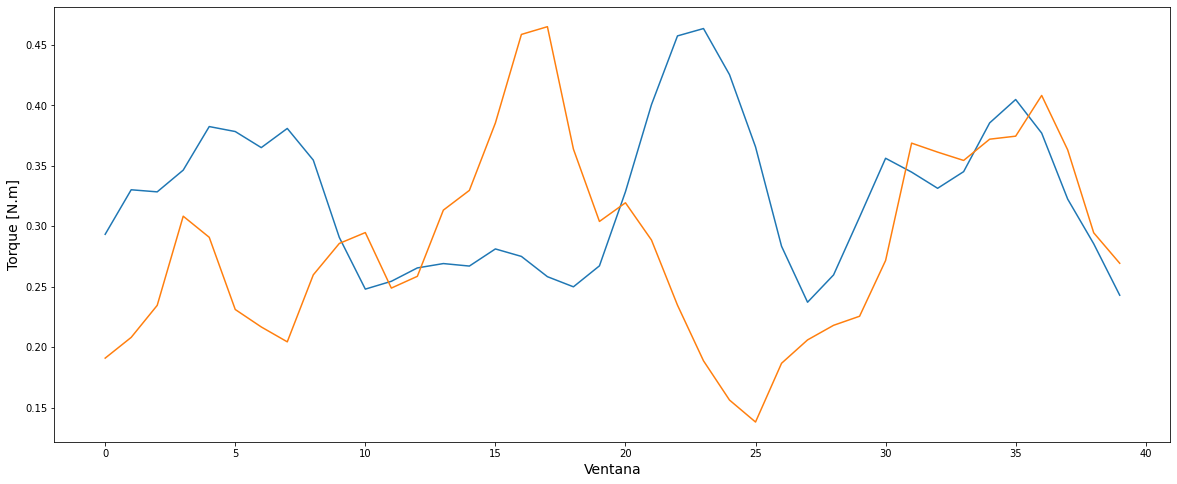

In [54]:
predicted = rf.predict(X_train_feat)
print("Train MAE = ", mean_absolute_error(Y_train_feat, predicted))
predicted = rf.predict(X_test_feat)
print("Test MAE = ", mean_absolute_error(Y_test_feat, predicted))

n = 40
plt.figure(figsize=(20,8))
plt.plot(Y_test_feat[0:n])
plt.plot(predicted[0:n])
plt.ylabel("Torque [N.m]", fontsize=14)
plt.xlabel("Ventana", fontsize=14)

In [15]:
deep_mlp = mlpReg()
deep_mlp.compile(optimizer='adam', loss='mean_squared_error', metrics=['MeanAbsoluteError','MeanSquaredError','RootMeanSquaredError'])
deep_mlp.fit(x=X_train_feat, y=Y_train_feat, epochs=200, batch_size=256)

Epoch 1/200
40/40 [==============================] - 1s 5ms/step - loss: 0.0585 - mean_absolute_error: 0.1800 - mean_squared_error: 0.0585 - root_mean_squared_error: 0.2419
Epoch 2/200
40/40 [==============================] - 0s 5ms/step - loss: 0.0426 - mean_absolute_error: 0.1519 - mean_squared_error: 0.0426 - root_mean_squared_error: 0.2063
Epoch 3/200
40/40 [==============================] - 0s 6ms/step - loss: 0.0410 - mean_absolute_error: 0.1475 - mean_squared_error: 0.0410 - root_mean_squared_error: 0.2026
Epoch 4/200
40/40 [==============================] - 0s 6ms/step - loss: 0.0404 - mean_absolute_error: 0.1457 - mean_squared_error: 0.0404 - root_mean_squared_error: 0.2009
Epoch 5/200
40/40 [==============================] - 0s 6ms/step - loss: 0.0401 - mean_absolute_error: 0.1460 - mean_squared_error: 0.0401 - root_mean_squared_error: 0.2004
Epoch 6/200
40/40 [==============================] - 0s 6ms/step - loss: 0.0397 - mean_absolute_error: 0.1445 - mean_squared_error: 0.0

In [16]:
deep_mlp.evaluate(X_train_feat,Y_train_feat)
deep_mlp.evaluate(X_test_feat,Y_test_feat)

36/36 [==============================] - 0s 4ms/step - loss: 0.0401 - mean_absolute_error: 0.1474 - mean_squared_error: 0.0401 - root_mean_squared_error: 0.2001


[0.04005219787359238,
 0.14744561910629272,
 0.04005219787359238,
 0.20013044774532318]

36/36 [==============================] - 0s 2ms/step


Text(0.5, 0, 'Ventana')

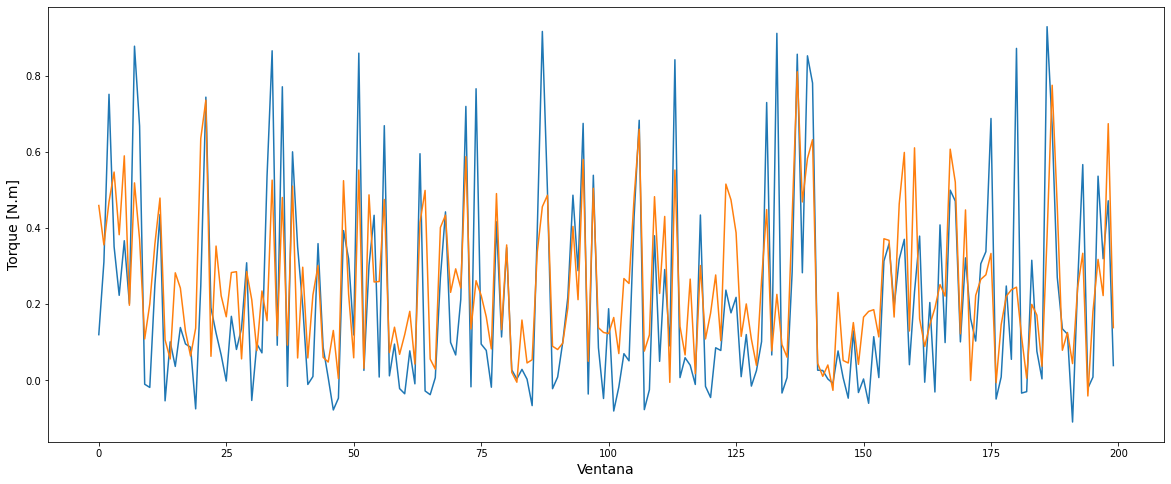

In [ ]:
predicted = deep_mlp.predict(X_test_feat)
n = 200
plt.figure(figsize=(20,8))
plt.plot(Y_test_feat[0:n])
plt.plot(predicted[0:n])
plt.ylabel("Torque [N.m]", fontsize=14)
plt.xlabel("Ventana", fontsize=14)